<a href="https://colab.research.google.com/github/LuanPCunha/TCC/blob/main/Treinamento_BiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports e definições de funções

In [40]:
# !pip install tensorflow
# !pip install keras

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
import json
import sklearn
import numpy as np
import pandas as pd
from numpy import loadtxt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras import layers
from keras.layers import Dropout, Conv1D, MaxPooling1D, Flatten, Dense, SpatialDropout1D, BatchNormalization
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, RMSprop, Adagrad, Adamax, Nadam, Ftrl
from keras.models import Sequential
from keras.layers.embeddings import Embedding

from mlxtend.plotting import plot_confusion_matrix
from keras.callbacks import Callback, ModelCheckpoint, CSVLogger
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from keras.callbacks import EarlyStopping

In [43]:
def tokenize(tweets_list):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(tweets_list)
    return tokenizer.texts_to_sequences(tweets_list), tokenizer

In [44]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            self.score = roc_auc_score(self.y_val, y_pred)
            self.false_positive_rate, self.true_positive_rate, _ = roc_curve(self.y_val, y_pred) 
                   

# Carrega arquivo de saída (resultados)

In [45]:
# CONSTANTES DOS RESULTADOS
REDE = 'Bi-LSTM'

BASE_NAME = 'BASE 0'
#BASE_NAME = 'BASE 1'
#BASE_NAME = 'BASE 2'

# Caminho arquivo de saída
PATH_ARQ_SAIDA = "/content/drive/MyDrive/TCC/resultados/resultados.csv"

#  rede base otimizador acuracia val_loss learning_rate dropout batch_size roc_curve train_resume confusion_matrix
resultados = pd.read_csv(PATH_ARQ_SAIDA, index_col=0)
resultados.head()

,rede,base,otimizador,acuracia,val_loss,learning_rate,dropout,batch_size,roc_curve,train_resume,confusion_matrix,epochs,rank
0,CNN,BASE 0,Nadam,0.905660,0.242821,0.0001,0.1,32,"{""false_positive_rate"": [0.0, 0.0, 0.0, 0.0, 0...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3, ""4""...","{""00"": 860, ""01"": 68, ""10"": 107, ""11"": 820}",3.729751,NaN
1,CNN,BASE 0,Nadam,0.907278,0.240671,0.0001,0.2,32,"{""false_positive_rate"": [0.0, 0.0, 0.0, 0.0, 0...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3, ""4""...","{""00"": 848, ""01"": 80, ""10"": 92, ""11"": 835}",3.769780,NaN
2,CNN,BASE 0,Nadam,0.908895,0.238317,0.0001,0.3,32,"{""false_positive_rate"": [0.0, 0.0, 0.0, 0.0, 0...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3, ""4""...","{""00"": 861, ""01"": 67, ""10"": 102, ""11"": 825}",3.813809,NaN
3,CNN,BASE 0,RMSProp,0.896496,0.242737,0.0001,0.1,32,"{""false_positive_rate"": [0.0, 0.0, 0.0, 0.0, 0...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3, ""4""...","{""00"": 842, ""01"": 86, ""10"": 106, ""11"": 821}",3.693281,NaN
4,CNN,BASE 0,RMSProp,0.900270,0.250310,0.0001,0.2,32,"{""false_positive_rate"": [0.0, 0.0, 0.0, 0.0, 0...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3, ""4""...","{""00"": 847, ""01"": 81, ""10"": 104, ""11"": 823}",3.596621,NaN


# Carrega base

In [46]:
# Base1 Com StopWords
PATH_BASE1_JUNTO_COM_DA_LEILA_BALANCEADA = "/content/drive/MyDrive/TCC/dados/processadas/balanceadas/Base1JuntaHateENotHateDaLeila_balanceada.csv"
#MATRIZ_CBOW_300_BASE_1 = loadtxt("/content/drive/MyDrive/TCC/dados/word_embeddings/Matriz_Base1JuntaHateENotHateDaLeila_balanceada_CBOW300.CSV", delimiter=',')

# Base2 Sem StopWords
PATH_BASE2_LEILA_LIMPISSIMA_BALANCEADA = "/content/drive/MyDrive/TCC/dados/processadas/balanceadas/Base2_maior4_menor25_limpissima_balanceada.csv"
#MATRIZ_CBOW_300_BASE_2_LEILA = loadtxt("/content/drive/MyDrive/TCC/dados/word_embeddings/Matriz_Base2_maior4_menor25_limpissima_balanceada_CBOW300.CSV", delimiter=',')

# Base0 Bruta Não processada
PATH_BASE0_NAO_PROCESSADA = "/content/drive/MyDrive/TCC/dados/processadas/balanceadas/Base0_classificada_balanceada.csv"

PATH_BASE_1_CLASSIFICADA_BALANCEADA = r"/content/drive/MyDrive/TCC/dados/processadas/balanceadas/Base1_classificada_balanceada.csv" #entrada

PATH_BASE_2_CLASSIFICADA_BALANCEADA = r"/content/drive/MyDrive/TCC/dados/processadas/balanceadas/Base2_classificada_balanceada.csv" #entrada
#MATRIZ_CBOW_300_BASE_2 = loadtxt("/content/drive/MyDrive/TCC/dados/word_embeddings/Matriz_Base2_classificada_balanceada_CBOW300.csv", delimiter=',') #saida

In [47]:
tweets = pd.read_csv(PATH_BASE0_NAO_PROCESSADA, index_col=0)
tweets

,text,label
0,RT @ThomasM71708305: @allantercalivre A Bahia ...,1
1,@allantercalivre @gen_heleno @CNNBrasil O Gene...,1
2,@allantercalivre @gen_heleno @CNNBrasil Alan t...,1
3,@allantercalivre @OlavoOpressor @opropriolavo ...,1
4,RT @ThomasM71708305: @allantercalivre A Bahia ...,1
...,...,...
9269,simplesmente amoooo https://t.co/I12jVsUdvb,0
9270,@Mary_Greicy Abençoado Ano Novo sua linda e q...,0
9271,"@MarcusConcolato leva eles com a gente, eles s...",0
9272,se tu NUNCA fumou maconha cole isso no seu mur...,0


In [48]:
# Pega a quantidade de palavras únicas dos tweets de toda a base
_, text_tokenizer = tokenize(tweets['text'])
text_vocab_size = len(text_tokenizer.word_index)
print("Vocabulary size:", text_vocab_size)

Vocabulary size: 24839


# Prepara os dados de train, test e validation da base


In [49]:
NUM_BASES = 4
# Carrega os paths das divisões das bases
LIST_PATH_TRAIN = []
LIST_PATH_TEST = []
LIST_PATH_VAL = []
for i in range(NUM_BASES):
  LIST_PATH_TRAIN.append('/content/drive/MyDrive/TCC/dados/processadas/bases_balanceadas_divididas/train'+str(i)+'.csv')
  LIST_PATH_TEST.append('/content/drive/MyDrive/TCC/dados/processadas/bases_balanceadas_divididas/test'+str(i)+'.csv')
  LIST_PATH_VAL.append('/content/drive/MyDrive/TCC/dados/processadas/bases_balanceadas_divididas/val'+str(i)+'.csv')

In [50]:
# 0 - Base0 bruta não processada
# 1 - Base1 Com StopWords
# 2 - Base2 Sem StopWords
# 3 - Base2 Nossa sem stopwords
base_index = int(BASE_NAME.split()[1])
base_train = pd.read_csv(LIST_PATH_TRAIN[base_index], index_col=0)
base_test = pd.read_csv(LIST_PATH_TEST[base_index], index_col=0)
base_val = pd.read_csv(LIST_PATH_VAL[base_index], index_col=0)

In [51]:
# Dados train
Y_TRAIN = base_train['label']
base_train.drop(['label'], axis='columns', inplace=True)
X_TRAIN = base_train.to_numpy()

# Dados test
Y_TEST = base_test['label']
base_test.drop(['label'], axis='columns', inplace=True)
X_TEST = base_test.to_numpy()

# Dados validation
Y_VAL = base_val['label']
base_val.drop(['label'], axis='columns', inplace=True)
X_VAL = base_val.to_numpy()

max_text_length = X_TRAIN.shape[1]

print(X_TRAIN.shape)
print(X_TEST.shape)
print(X_VAL.shape)

(5564, 72)
(1855, 72)
(1855, 72)


# Execução modelo

In [52]:
# parametros tunning:
BATCH_SIZE = [32, 64]
LEARN_RATE = [0.0001, 0.001]
OTMIZADORES = ['Nadam', 'RMSProp', 'SGD']
DROPOUT = [0.1, 0.2, 0.3]

# parametros estaticos:
EPOCHS = 10
EMBEDDING_DIMENSION = 300  
MAX_TEXT_SIZE = max_text_length 
VOCAB_SIZE = text_vocab_size

In [53]:
def optimize (optimize, learning_rate):
  if optimize == 'Nadam':
    return Nadam(learning_rate=learning_rate, name="Nadam")
  
  if optimize == 'RMSProp':
    return RMSprop(learning_rate=learning_rate, name="RMSprop")
  
  if optimize == 'SGD':
    return SGD(learning_rate=learning_rate, name="SGD")

In [54]:
def create_bilstm (vocab_size, embedding_dimen, max_text_size, dropout_rate ):
  forward_layer = keras.layers.LSTM(max_text_size, dropout=dropout_rate)
  backward_layer = keras.layers.LSTM(max_text_size, dropout=dropout_rate)
  
  modelo = keras.Sequential([
    keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIMENSION, input_length=max_text_size),
    # keras.layers.Embedding(input_dim=MATRIZ_CBOW_300_BASE_2.shape[0],
                            # output_dim=MATRIZ_CBOW_300_BASE_2.shape[1],
                            # weights=[MATRIZ_CBOW_300_BASE_2],
                            # embeddings_initializer=keras.initializers.Constant(MATRIZ_CBOW_300_BASE_2),
                            # input_length=max_text_size,
                            # trainable=True),
    #keras.layers.Bidirectional(layers.LSTM(50, dropout=0.15, name="LSTM")),
    keras.layers.Bidirectional(forward_layer, backward_layer=backward_layer),
    keras.layers.Dense(1, activation='sigmoid')
    ])

  return modelo  

In [55]:
def train_model(embedding_dimen, batch_size, epochs, learning_rate, optimizer, dropout_rate):
    opt = optimize(optimizer, learning_rate)
    
    model = create_bilstm(VOCAB_SIZE, EMBEDDING_DIMENSION, MAX_TEXT_SIZE, dropout_rate)

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=opt, metrics=['accuracy'])        
    
    ra_val = RocAucEvaluation(validation_data=(X_VAL, Y_VAL), interval = 1)
    
    csv_logger = CSVLogger('log.csv', append=False, separator=';')

    early_stop = EarlyStopping(monitor = "val_loss", mode = "min", verbose = 0, patience = 1)                                                                                       
   
    history = model.fit(X_TRAIN, Y_TRAIN, batch_size=batch_size, epochs=epochs, validation_data=(X_VAL, Y_VAL), verbose=0, use_multiprocessing=True,  callbacks = [ra_val, csv_logger, early_stop])
    
    scores = model.evaluate(X_TEST, Y_TEST, verbose=0)
    
    return history, model, ra_val, scores, csv_logger


In [57]:
history, model1, ra_val, scores, csv_logger = train_model(EMBEDDING_DIMENSION, 32, 10, 0.001, 'Nadam', 0.2)

ValueError: ignored

In [58]:
my_log = pd.read_csv('log.csv',sep=';')
my_log

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.666068,0.600566,0.807547,0.432336
1,1,0.914270,0.231864,0.921294,0.219413
2,2,0.983825,0.060482,0.913208,0.274649


In [ ]:
# plot dos gráficos
count = 1
for BS in BATCH_SIZE:
  for LR in LEARN_RATE:
    for OT in OTMIZADORES:
      for DO in DROPOUT:
        print("Iteração "+str(count))
        count+=1
        
        history, model1, ra_val, scores, csv_logger = train_model(EMBEDDING_DIMENSION, BS, EPOCHS, LR, OT, DO)

        #
        y_predito = model1.predict(X_TEST).round()
        y_gabarito = Y_TEST
        
        # Parâmetros
        # rede base otimizador acuracia val_loss learning_rate dropout batch_size roc_curve train_resume confusion_matrix
        NOME_REDE = REDE
        NOME_BASE = BASE_NAME
        NOME_OTIMIZADOR = OT
        ACURACIA = scores[1]
        LOSS = scores[0] 
        LEARNING_RATE = LR
        DROPOUT_RATE = DO
        BATCH = BS
        ROC_CURVE = json.dumps({
            "false_positive_rate": list(ra_val.false_positive_rate),
            "true_positive_rate": list(ra_val.true_positive_rate),
            "score": ra_val.score})
        TRAIN_RESUME = json.dumps(pd.read_csv('log.csv',sep=';').to_dict()) 
        
        confusion = confusion_matrix(y_gabarito, y_predito)
        CONFUSION_MATRIX = json.dumps({
            "00": int(confusion[0][0]),
            "01": int(confusion[0][1]),
            "10": int(confusion[1][0]),
            "11": int(confusion[1][1])
        })

        EPOCHS = len(history.history['val_loss'])
        RANK = ACURACIA/LOSS
 
        # Salvando resultado do modelo
        registro_resultado = {resultados.columns[0]: NOME_REDE, 
                              resultados.columns[1]: NOME_BASE, 
                              resultados.columns[2]: NOME_OTIMIZADOR,
                              resultados.columns[3]: ACURACIA, 
                              resultados.columns[4]: LOSS,
                              resultados.columns[5]: LEARNING_RATE,
                              resultados.columns[6]: DROPOUT_RATE,
                              resultados.columns[7]: BATCH,
                              resultados.columns[8]: ROC_CURVE,
                              resultados.columns[9]: TRAIN_RESUME,
                              resultados.columns[10]: CONFUSION_MATRIX,
                              resultados.columns[11]: EPOCHS,
                              resultados.columns[12]: RANK,
                            }

        resultados = resultados.append(registro_resultado, ignore_index=True)

In [ ]:
resultados

In [ ]:
# Caso queira deletar uma linha use o código abaixo
# Use a propriedade label para especificar o índice da linha
#resultados = resultados.drop(labels=1, axis=0)
#resultados = resultados.reset_index(drop=True)
#resultados

In [ ]:
# Salva arquivo de saída
resultados.to_csv(PATH_ARQ_SAIDA)

In [ ]:
# Fazer a separação de Treinamento, Teste e validação 
  # Alterar todos os modelos para ler desse novo jeito
# Ver NaiveBayes, colocar na tabela
  # Falta salvar o treinamento no arquivo de resultados
# Ver ShallowNet, colocar na tabela
  # ler igual a tarefa1
# Rever LSTM
  # rever o foward e backward layer
# Prioridade é fechar o Resultado ( Tabelas )
  # Rodar tudo
# Ajustar Tabelas ( embelezar )
# Ajustar Graficos ( embelezar )
# Ver BiLstm / Otmizador 
# Gerar e Salvar os Graficos 
# Escrever Resultados
# Revisar Monografia
# Preparar apresentação

grafico Acuracy b1  
		b1 cnn melhor
		b1 lstm melhor
		.
		.

grafico Loss b1  
		b1 cnn melhor
		b1 lstm melhor
		.
		.

grafico Acuracy b2 
		b2 cnn melhor
		b2 lstm melhor
		.
		.

grafico Loss b2 
		b2 cnn melhor
		b2 lstm melhor
		.
		.

grafico Acuracy b0
		bo cnn melhor
		b0 lstm melhor

grafico Loss b0
		b0 cnn melhor
		b0 lstm melhor
		.
		.


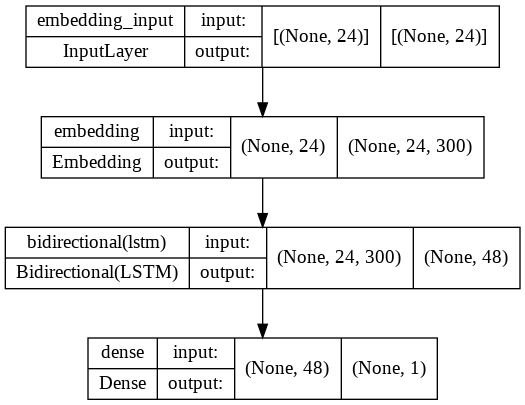

In [20]:
tf.keras.utils.plot_model(model1, to_file='/meuarquivo.png', show_shapes=True)